Script below deals with loading the real train data and the synthetic data that's created using the real train data through Gaussian Copula (with added noise), along with real test data. Since both real and synthetic datasets are imbalanced, we're oversampling minority class.

Then Logistic regression models (with and without validation) and XGBoost (without validation) models are trained on both oversampled real and oversampled synthetic datasets separately, and tested on the real test data.

Summary statistics like accuracy, precision, AUC, Recall, Confusion matrices etc. are printed for easy comparison.


In [1]:
#!pip uninstall scikit-learn --yes
#!pip uninstall imblearn --yes
#!pip install scikit-learn==1.2.2
#!pip install imblearn

In [2]:
#Import required modules and packages
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Function to load data and replace or remove problematic characters in column names
def load_and_preprocess(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = [name.replace('[', '').replace(']', '').replace('<', '') for name in df.columns]
    df.columns = df.columns.map(str)  # Ensure column names are strings
    X = df.drop('Viral_sinusitis_present', axis=1)
    y = df['Viral_sinusitis_present']
    return X, y

In [4]:
# Function to evaluate model
def evaluate_model(model, X_test, y_test, title='Confusion Matrix'):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

    print(classification_report(y_test, y_pred))

    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
# Load and preprocess data
real_train_path = 'real_train.csv'  # Update paths if necessary
synthetic_train_path = 'synthetic_dataset_GaussianCopula_without_noise.csv'
real_test_path = 'real_test.csv'

X_train, y_train = load_and_preprocess(real_train_path)
X_synthetic, y_synthetic = load_and_preprocess(synthetic_train_path)
X_test, y_test = load_and_preprocess(real_test_path)

In [6]:
# Apply SMOTE to balance the datasets
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_synthetic_smote, y_synthetic_smote = smote.fit_resample(X_synthetic, y_synthetic)

In [7]:
# Function to print summary statistics of class distribution
def print_summary(y_before, y_after, dataset_name):
    before_counts = y_before.value_counts().sort_index()
    after_counts = y_after.value_counts().sort_index()
    print(f'{dataset_name} Dataset:')
    print(f'Before SMOTE: {before_counts.to_dict()}')
    print(f'After SMOTE: {after_counts.to_dict()}\n')

# Original class distribution before SMOTE
print_summary(y_train, y_train_smote, 'Real Train')
print_summary(y_synthetic, y_synthetic_smote, 'Synthetic')

Real Train Dataset:
Before SMOTE: {0: 46912, 1: 13679}
After SMOTE: {0: 46912, 1: 46912}

Synthetic Dataset:
Before SMOTE: {0: 46944, 1: 13647}
After SMOTE: {0: 46944, 1: 46944}



Evaluating model trained on SMOTE-balanced original full data on the original test set:
Accuracy: 0.80


/Users/kyu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


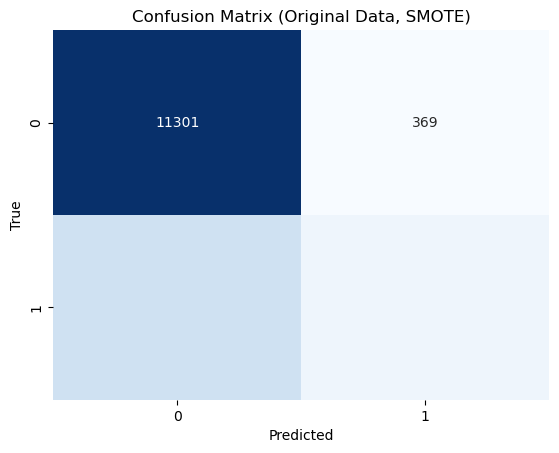

              precision    recall  f1-score   support

           0       0.81      0.97      0.88     11670
           1       0.70      0.25      0.36      3478

    accuracy                           0.80     15148
   macro avg       0.76      0.61      0.62     15148
weighted avg       0.79      0.80      0.76     15148



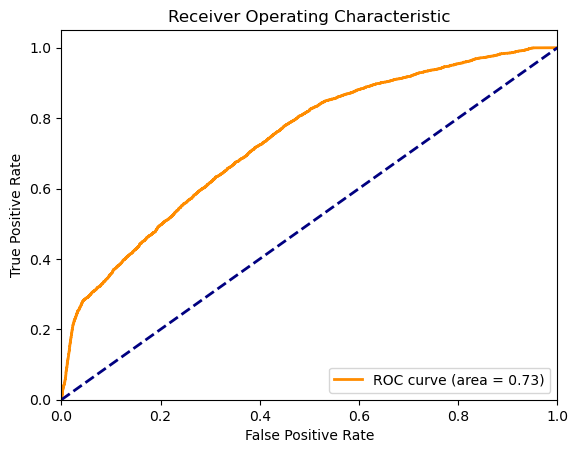

Evaluating model trained on SMOTE-balanced synthetic full data on the original test set:
Accuracy: 0.73


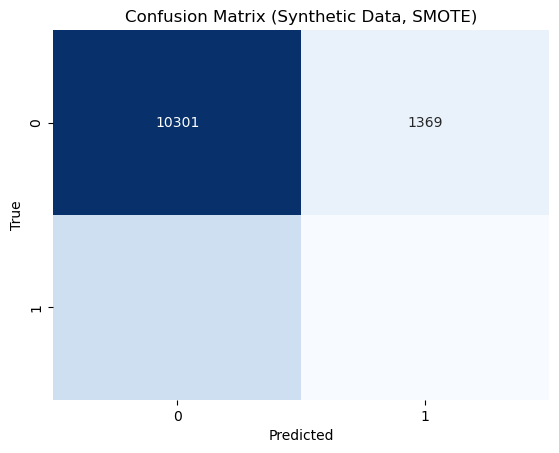

              precision    recall  f1-score   support

           0       0.79      0.88      0.83     11670
           1       0.33      0.20      0.25      3478

    accuracy                           0.73     15148
   macro avg       0.56      0.54      0.54     15148
weighted avg       0.68      0.73      0.70     15148



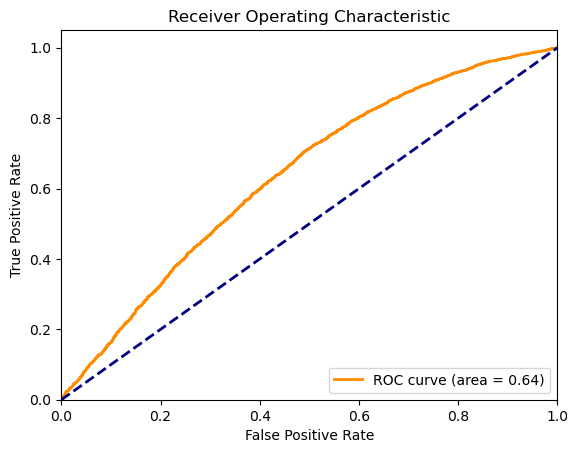

In [8]:
# Train and evaluate models on the balanced datasets
# For original data
lr_model_original_smote = LogisticRegression(max_iter=10000)
lr_model_original_smote.fit(X_train_smote, y_train_smote)
print("Evaluating model trained on SMOTE-balanced original full data on the original test set:")
evaluate_model(lr_model_original_smote, X_test, y_test, title='Confusion Matrix (Original Data, SMOTE)')

# For synthetic data
lr_model_synthetic_smote = LogisticRegression(max_iter=10000)
lr_model_synthetic_smote.fit(X_synthetic_smote, y_synthetic_smote)
print("Evaluating model trained on SMOTE-balanced synthetic full data on the original test set:")
evaluate_model(lr_model_synthetic_smote, X_test, y_test, title='Confusion Matrix (Synthetic Data, SMOTE)')

Accuracy (SMOTE-balanced Original Data): 0.79


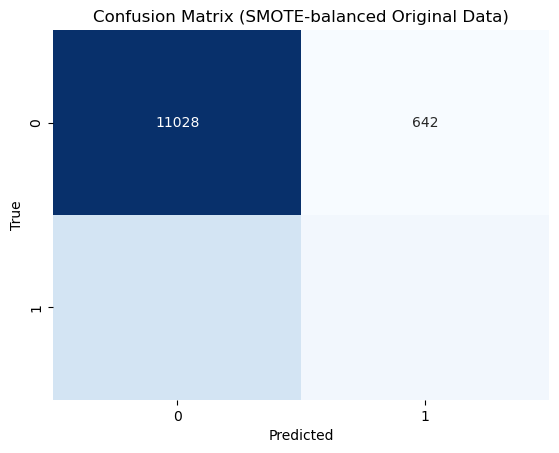

Classification Report (SMOTE-balanced Original Data):
              precision    recall  f1-score   support

           0       0.81      0.94      0.87     11670
           1       0.60      0.28      0.38      3478

    accuracy                           0.79     15148
   macro avg       0.71      0.61      0.63     15148
weighted avg       0.77      0.79      0.76     15148



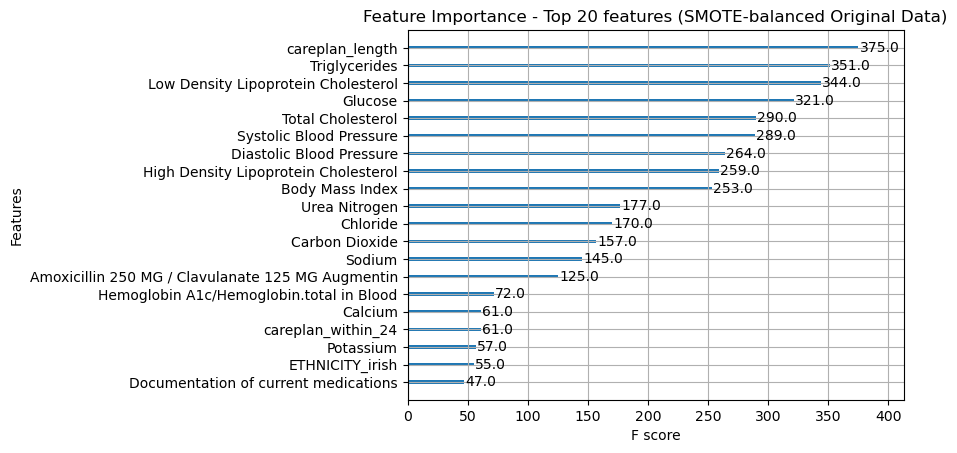

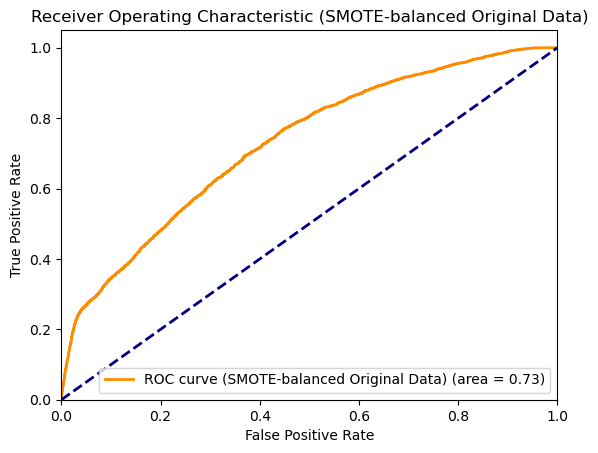

Accuracy (SMOTE-balanced Synthetic Data): 0.73


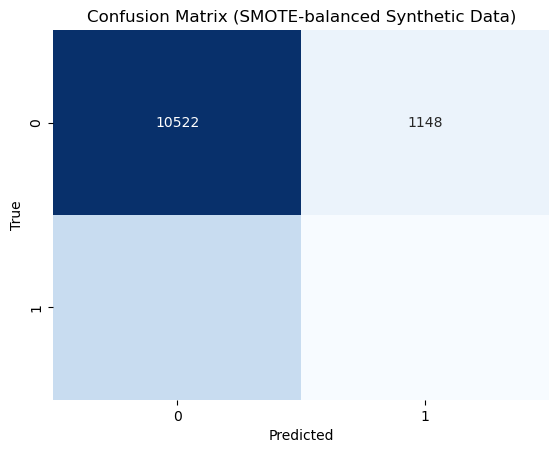

Classification Report (SMOTE-balanced Synthetic Data):
              precision    recall  f1-score   support

           0       0.78      0.90      0.84     11670
           1       0.32      0.16      0.21      3478

    accuracy                           0.73     15148
   macro avg       0.55      0.53      0.52     15148
weighted avg       0.68      0.73      0.69     15148



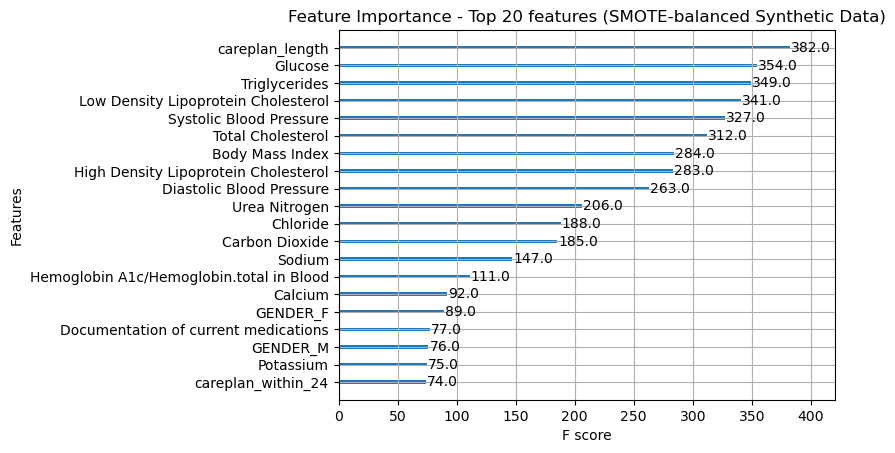

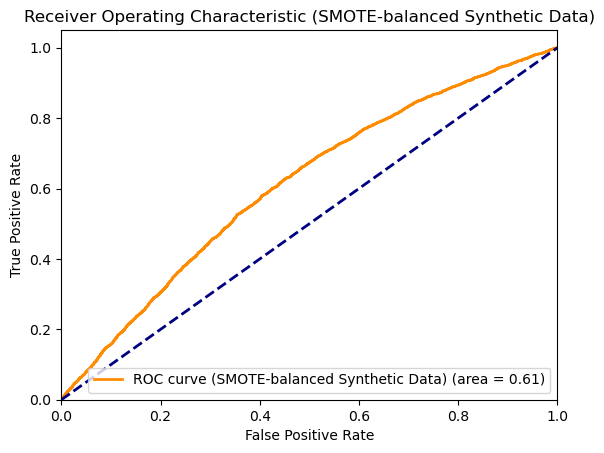

In [10]:
### import xgboost as xgb

# Function to train and evaluate the model
def train_and_evaluate_xgb(X_train, y_train, X_test, y_test, dataset_name):
    # Initialize and train the XGBoost model
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = xgb_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy ({dataset_name}): {accuracy:.2f}')

    # Generate and visualize the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix ({dataset_name})')
    plt.show()

    # Print classification report
    print(f'Classification Report ({dataset_name}):')
    print(classification_report(y_test, y_pred))

    # Plot feature importance
    xgb.plot_importance(xgb_model, max_num_features=20, importance_type='weight')
    plt.title(f'Feature Importance - Top 20 features ({dataset_name})')
    plt.show()

    # Predict probabilities for the positive class
    y_score = xgb_model.predict_proba(X_test)[:, 1]

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve ({dataset_name}) (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic ({dataset_name})')
    plt.legend(loc="lower right")
    plt.show()

# Train and evaluate XGBoost models on SMOTE-balanced original and synthetic datasets
train_and_evaluate_xgb(X_train_smote, y_train_smote, X_test, y_test, 'SMOTE-balanced Original Data')
train_and_evaluate_xgb(X_synthetic_smote, y_synthetic_smote, X_test, y_test, 'SMOTE-balanced Synthetic Data')
